# Arima

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                ARIMA(15, 0, 3)   Log Likelihood               -1253.576
Date:                Wed, 29 Nov 2023   AIC                           2547.152
Time:                        23:19:06   BIC                           2645.308
Sample:                             0   HQIC                          2584.458
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0085      2.815     -0.003      0.998      -5.526       5.509
ar.L1          1.6702     32.539      0.051      0.959     -62.106      65.446
ar.L2         -0.9042     21.784     -0.042      0.9

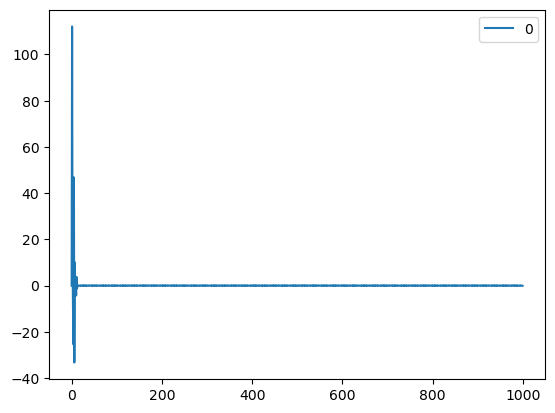

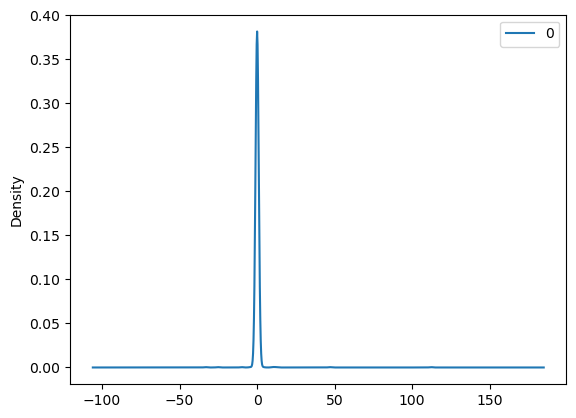

                 0
count  1000.000000
mean      0.112300
std       4.110686
min     -33.244623
25%      -0.056819
50%       0.008596
75%       0.049065
max     112.113039


array([ 125.75242975, -125.32727032,   39.41733768,    9.31684877,
         56.36331164, -178.09435313,  229.65824992, -164.0576901 ,
         67.93689319,  -60.50806095])

In [1]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn           as sns
from statsmodels.tsa.arima.model import ARIMA

# Fibonacci series
Serie = [ 100*np.sin(2*x)+150*np.sin(3*x) for x in range(1000)]
    
# Split the series into training and prediction data
train   = Serie

# Initialize the ARIMA model with the selected parameters
model = ARIMA(
    endog                  =  train,
    order                  = (15,0,3),
    seasonal_order         = (0, 0, 0, 0),
    trend_offset           =  1,
    trend                  =  None,
    exog                   =  None,
    dates                  =  None,
    freq                   =  None,
    enforce_stationarity   =  True,
    enforce_invertibility  =  True,
    validate_specification =  True,
    concentrate_scale      =  False,
    missing                = 'none'
).fit()

# summary of fit model
print(model.summary())

# line plot of residuals
residuals = pd.DataFrame(model.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()

# summary stats of residuals
print(residuals.describe())

# forecasting 
model.forecast(steps=10) 

# Forcasting Future n Steps 

In [2]:
# forcasting
n    =   50
PRED = model.forecast(steps=n)
TRUE = [ 100*np.sin(2*x)+150*np.sin(3*x) for x in range(1000,1000+n,1)]
RMSE = (np.sum((TRUE - PRED)**2)/n)**0.5
RMSE

0.15138893625736907

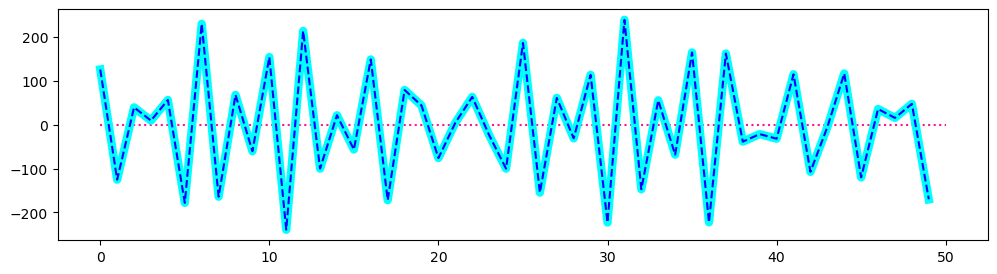

In [3]:
# visualizing
plt.figure( figsize=(12,3) )
plt.plot( [0,n], [0,0] ,":" ,color='deeppink' )
plt.plot( range(n),TRUE,"-" ,color='cyan',linewidth=6)
plt.plot( range(n),PRED,"--",color='blue'     )

#####   

#####   